In [1]:
%run Thesis_Model_Function.ipynb 

Run Complete: 14/07/2024 11:53:40


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pm
from functools import reduce
# Description of each DataFrame found within
# swe_raw_pop_data - Raw population data from source. population per month for 4 regions in single year age groups. 
# swe_pop_grouped - Sweden population grouped by REGION and SINGLE YEAR AGE groups
# swe_pop_age_grouped - Sweden Population Age Grouped by REGION and  AGE BAND
# all_swe_pop - All Sweden Population. No regional grouping, SINGLE YEAR AGE GROUPS
# all_swe_pop_age All Sweden Population with age bands 
# swe_pop_region_dict - Dictionary containing data frame for population of each region SINGLE YEAR AGE GROUPS. 



############################# Formatting Sweden regional population data ########################
pop_path = "/Users/darraghspillane/Documents/Transfer to Macbook/Groningen Masters/Thesis/Data/Sweden/SWE_Pop_Metro_Month_1Year.xlsx"
#pop_path = "/Users/darraghspillane/Documents/Transfer to Macbook/SWE_Pop_Metro_Month_1Year.xlsx"
swe_raw_pop_data = pd.read_excel(pop_path,skiprows = 2)
swe_raw_pop_data = swe_raw_pop_data.drop(["age_raw"],axis = 1)

### changes pop data to person days - population times number of days in corresponding month
swe_raw_pop_data = person_days(swe_raw_pop_data)


# Split the age column so that it is just a number and add to raw data  
swe_pop_ages = swe_raw_pop_data["age"]
ages_split = swe_pop_ages.str.split(" ",expand = True)
ages_split.columns = ["Age_num","years"]
ages_split = ages_split.drop(["years"],axis = 1)
ages_split['Age_num'] = ages_split['Age_num'].map(lambda x: x.rstrip('+'))  #### all ages 100+ are down as just 100
ages_split["Age_num"] = pd.to_numeric(ages_split["Age_num"])
swe_raw_pop_data.insert(2,"Age_num",ages_split["Age_num"])

## population data grouped by age (single year) and region (removing the sex)
swe_pop_grouped = swe_raw_pop_data.groupby(["Region","Age_num"]).sum()
swe_pop_grouped = swe_pop_grouped.reset_index(level = [0,1])
swe_pop_grouped = swe_pop_grouped.drop(["age","sex"],axis = 1)

## Entire population of sweden for each age group - Region split removed 
all_swe_pop = swe_pop_grouped.groupby(["Age_num"]).sum()
all_swe_pop = all_swe_pop.drop(["Region"],axis = 1)
all_swe_pop = all_swe_pop.reset_index()


# Create dictionary where each element is a dataframe for the population in each region
swe_pop_region_dict = {elem : pd.DataFrame() for elem in swe_pop_grouped["Region"].unique()}
for key in swe_pop_region_dict.keys():
    swe_pop_region_dict[key] = swe_pop_grouped[:][swe_pop_grouped.Region == key]
    

# Function defines the groupings for the ages (should be same groupings as deaths)
def age_grouping(df):
    if (df["Age_num"] < 35):
        return "0-34 years"
    elif (df["Age_num"] >= 35) and (df["Age_num"] < 65):
        return "35-64 years"
    elif (df["Age_num"] >= 65) and (df["Age_num"] < 75):
        return "65-74 years"
    elif (df["Age_num"] >= 75) and (df["Age_num"] < 85):
        return "75-84 years"
    elif (df["Age_num"] >= 85):
        return "85+ years"
    
# create new column for age band using function defined above 
swe_pop_grouped["age_band"] = swe_pop_grouped.apply(age_grouping,axis = 1)
all_swe_pop["age_band"] = all_swe_pop.apply(age_grouping,axis = 1)


#population grouped by region and age band
swe_pop_age_grouped = swe_pop_grouped.groupby(["Region","age_band"]).sum() 
swe_pop_age_grouped = swe_pop_age_grouped.drop(["Age_num"],axis = 1)
swe_pop_age_grouped = swe_pop_age_grouped.reset_index(level = [0,1])

#population for all sweden grouped by age band
all_swe_pop_age = all_swe_pop.groupby(["age_band"]).sum() 
all_swe_pop_age = all_swe_pop_age.drop(["Age_num"],axis = 1)
all_swe_pop_age = all_swe_pop_age.reset_index()
all_swe_pop_age = all_swe_pop_age.drop(["2023M01","2023M02","2023M03","2023M04","2023M05","2023M06","2023M07","2023M08","2023M09"],axis = 1)  # drop 2023 months   



########## Formatting Sweden regional death data (same procedure and format as population data) ###############
death_path = "/Users/darraghspillane/Documents/Transfer to Macbook/Groningen Masters/Thesis/Data/Sweden/SWE_Death_Metro_Month.xlsx"

swe_raw_death_data = pd.read_excel(death_path,sheet_name = "Formatted Data",skiprows = 3)
swe_death_grouped = swe_raw_death_data.groupby(["Region","Age"]).sum()
swe_death_grouped = swe_death_grouped.reset_index(level = [0,1])
swe_death_grouped = swe_death_grouped.drop(["Born","Sex"],axis = 1)

all_swe_death = swe_death_grouped.groupby(["Age"]).sum()
all_swe_death = all_swe_death.drop(["Region"],axis = 1)
all_swe_death = all_swe_death.reset_index()

swe_death_region_dict = {elem:pd.DataFrame() for elem in swe_death_grouped["Region"].unique()}

for key in swe_death_region_dict.keys():
    swe_death_region_dict[key] = swe_death_grouped[:][swe_death_grouped.Region == key]


#set indexes to be the same so deaths can be divided by population
all_swe_pop_age = all_swe_pop_age.set_index("age_band")
all_swe_death = all_swe_death.set_index("Age")

# All Sweden mortality and log mortality rate for each age group
all_swe_mort = all_swe_death.divide(all_swe_pop_age)
all_swe_logmort = np.log(all_swe_mort)


# create tables for population of each region in age bands
swe_pop_grouped_band = swe_pop_grouped.groupby(["Region",'age_band']).sum()
swe_pop_grouped_band = swe_pop_grouped_band.reset_index(level = [0,1])
swe_pop_grouped_band =  swe_pop_grouped_band.drop(["Age_num"],axis = 1)

####################### apply moving average to remove annomaly of increased population at the start of each year 
#swe_pop_grouped_band.iloc[:,2:] = ma_smoothing(swe_pop_grouped_band.iloc[:,2:],window_size = 12)
swe_pop_grouped_band.iloc[:,2:] = distribute_pop(swe_pop_grouped_band.iloc[:,2:])


swe_pop_region_dict_band = {elem : pd.DataFrame() for elem in swe_pop_grouped_band["Region"].unique()}
for key in swe_pop_region_dict_band.keys():
    swe_pop_region_dict_band[key] = swe_pop_grouped_band[:][swe_pop_grouped_band.Region == key]
    
    
# create log mortality tables for each region 
region_logmort_dict = {}
for r in swe_pop_region_dict_band.keys():
    population = swe_pop_region_dict_band[r]
    population = population.set_index(["age_band","Region"])
    deaths = swe_death_region_dict[r]
    deaths = deaths.set_index(["Age","Region"])
    mort_rate = deaths.divide(population)
    mort_rate = mort_rate.drop(["2020M01","2020M02","2020M03","2020M04","2020M05","2020M06","2020M07","2020M08","2020M09","2020M10","2020M11","2020M12","2021M01","2021M02","2021M03","2021M04","2021M05","2021M06","2021M07","2021M08","2021M09","2021M10","2021M11","2021M12","2022M01","2022M02","2022M03","2022M04","2022M05","2022M06","2022M07","2022M08","2022M09","2022M10","2022M11","2022M12","2023M01","2023M02","2023M03","2023M04","2023M05","2023M06","2023M07","2023M08","2023M09"],axis = 1)
    logmort_rate  = np.log(mort_rate)
    region_logmort_dict.update({r:logmort_rate})
    

region_logmort_dict_full = {}    
for r in swe_pop_region_dict_band.keys():
    pop = swe_pop_region_dict_band[r]
    pop = pop.set_index(["age_band","Region"])
    deaths = swe_death_region_dict[r]
    deaths = deaths.set_index(["Age","Region"])
    mort_rate = deaths.divide(pop)
    logmort_rate  = np.log(mort_rate)
    region_logmort_dict_full.update({r:logmort_rate})
    

stock_logmort_full = region_logmort_dict_full['0010 Greater Stockholm'].reset_index().drop(["Age","Region"],axis = 1)
stock_logmort_full = stock_logmort_full.drop(["2023M01","2023M02","2023M03","2023M04","2023M05","2023M06","2023M07","2023M08","2023M09"],axis = 1)
stock_logmort_full.index = region_logmort_dict_full["0010 Greater Stockholm"].index.get_level_values(0)
stock_logmort_incCOVID = stock_logmort_full
stock_logmort_full = stock_logmort_full.iloc[:,:84]  # remove COVID period

goth_logmort_full = region_logmort_dict_full['0020 Greater Gothenburg'].reset_index().drop(["Age","Region"],axis = 1)
goth_logmort_full = goth_logmort_full.drop(["2023M01","2023M02","2023M03","2023M04","2023M05","2023M06","2023M07","2023M08","2023M09"],axis = 1)
goth_logmort_full.index = region_logmort_dict_full["0020 Greater Gothenburg"].index.get_level_values(0)
goth_logmort_incCOVID = goth_logmort_full
goth_logmort_full = goth_logmort_full.iloc[:,:84] # remove COVID period

malmo_logmort_full = region_logmort_dict_full['0030 Greater Malmö'].reset_index().drop(["Age","Region"],axis = 1)
malmo_logmort_full = malmo_logmort_full.drop(["2023M01","2023M02","2023M03","2023M04","2023M05","2023M06","2023M07","2023M08","2023M09"],axis = 1)
malmo_logmort_full.index = region_logmort_dict_full["0030 Greater Malmö"].index.get_level_values(0)
malmo_logmort_incCOVID = malmo_logmort_full
malmo_logmort_full = malmo_logmort_full.iloc[:,:84] # remove COVID period

all_swe_logmort_incCOVID = all_swe_logmort
all_swe_logmort = all_swe_logmort.iloc[:,:84]

/var/folders/2j/kxsv0_2s1sz1xc52gtws5brr0000gn/T/ipykernel_25137/3558752759.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  swe_raw_pop_data.insert(2,"Age_num",ages_split["Age_num"])


In [3]:
import warnings
warnings.filterwarnings("ignore")

weather_data = pd.read_excel(r"/Users/darraghspillane/Documents/Transfer to Macbook/Groningen Masters/Thesis/Data/Sweden/Weather Data/Weather Data Master.xlsx")
weather_data['month_year'] = weather_data['datetime'].dt.to_period('M')



def temp_variable(data,factors,aggregation = "max",count = False,count_greater = True,count_value = None ):
    selection = data[np.append(["name","month_year"],factors)]
    
    if aggregation == "max" and not count:
        out = selection.groupby(["name","month_year"]).max()
        out = out.reset_index()
        return out
    
    if aggregation == "min" and not count:
        out = selection.groupby(["name","month_year"]).min()
        out = out.reset_index()
        return out
    
    if aggregation == "mean" and not count:
        out = selection.groupby(["name","month_year"]).mean()
        out = out.reset_index()
        return out
    
    if aggregation == "median" and not count:
        out = selection.groupby(["name","month_year"]).median()
        out = out.reset_index()
        return out
    
    if count and count_greater:
        
        selection["count"] = selection[factors] > count_value
        out = selection.groupby(["name","month_year"]).sum()
        out = out.reset_index()
        #out = out["name","month_year","threshold"]
        return out[["name","month_year","count"]]
    
    if count and not count_greater:
        
        selection["count"] = selection[factors] < count_value
        out = selection.groupby(["name","month_year"]).sum()
        out = out.reset_index()
        #out = out["name","month_year","threshold"]
        return out[["name","month_year","count"]]


temp_variable(weather_data,["tempmax"],aggregation = "max",count = True,count_greater = True,count_value = 10)

monthly_tempmax = temp_variable(weather_data,["temp"],aggregation = "max")
#print(weather_data.columns)


monthly_maxtemp = temp_variable(weather_data,["temp"],aggregation = "max")
monthly_maxtemp.rename(columns = {"temp": "monthly_maxtemp"}, inplace = True)

monthly_mintemp = temp_variable(weather_data,["temp"],aggregation = "min")
monthly_mintemp.rename(columns = {"temp": "monthly_mintemp"}, inplace = True)

monthly_avgtemp = temp_variable(weather_data,["temp"],aggregation = "mean")
monthly_avgtemp.rename(columns = {"temp": "monthly_avgtemp"}, inplace = True)

monthly_belowtemp_count = temp_variable(weather_data,["temp"],count = True,count_greater = False,count_value = 0)
monthly_belowtemp_count.rename(columns = {"count": "days_below_7"}, inplace = True)

monthly_abovetemp_count = temp_variable(weather_data,["temp"],count = True,count_greater = True,count_value = 20)
monthly_abovetemp_count.rename(columns = {"count": "days_above_20"}, inplace = True)

monthly_avghumidity = temp_variable(weather_data,["humidity"],aggregation = "mean")
monthly_avghumidity.rename(columns = {"humidity": "monthly_avghumidity"}, inplace = True)

#pd.merge(monthly_maxtemp,monthly_mintemp,on = ["name","month_year"])

dfs = [monthly_maxtemp,monthly_mintemp,monthly_avgtemp,monthly_belowtemp_count,monthly_avghumidity,monthly_abovetemp_count]

temp_factors = reduce(lambda  left,right: pd.merge(left,right,on=["name","month_year"],
                                            how='outer'), dfs)


exog_train_stock,exog_test_stock = exog_variables(temp_factors,"stockholm")
exog_train_goth,exog_test_goth = exog_variables(temp_factors,"Gothenburg")
exog_train_malmo,exog_test_malmo = exog_variables(temp_factors,"malmo")

exog_train_stock_COVID,exog_test_stock_COVID = exog_variables(temp_factors,"stockholm",train_period = 84,test_period = 36)
exog_train_malmo_COVID,exog_test_malmo_COVID = exog_variables(temp_factors,"malmo",train_period = 84,test_period = 36)
exog_train_goth_COVID,exog_test_goth_COVID = exog_variables(temp_factors,"Gothenburg",train_period = 84,test_period = 36)


exog_train_stock_select,exog_test_stock_select = exog_variables(temp_factors,"stockholm",train_period = 40,test_period = 20)
exog_train_malmo_select,exog_test_malmo_select = exog_variables(temp_factors,"malmo",train_period = 40,test_period = 20)
exog_train_goth_select,exog_test_goth_select = exog_variables(temp_factors,"Gothenburg",train_period = 40,test_period = 20)


In [4]:
## School Holiday Data 
holiday_path = "/Users/darraghspillane/Documents/Transfer to Macbook/Groningen Masters/Thesis/Data/Sweden/School Holidays/School Holidays Data.xlsx"
stock_hols = pd.read_excel(holiday_path,sheet_name = "Stockholm_Formatted",skiprows = 2)
malmo_hols = pd.read_excel(holiday_path,sheet_name = "Malmo_Formatted",skiprows = 2)
goth_hols = pd.read_excel(holiday_path,sheet_name = "Gothenburg_Formatted",skiprows = 2)

exog_train_stock["hols"] = np.reshape(np.array(stock_hols.iloc[:,:60]),(60,1))
exog_test_stock["hols"] = np.reshape(np.array(stock_hols.iloc[:,60:84]),(24,1))
exog_train_stock_COVID["hols"] = np.reshape(np.array(stock_hols.iloc[:,:84]),(84,1))
exog_test_stock_COVID["hols"] = np.reshape(np.array(stock_hols.iloc[:,84:]),(36,1))
exog_train_stock_select["hols"] = np.reshape(np.array(stock_hols.iloc[:,:40]),(40,1))
exog_test_stock_select["hols"] = np.reshape(np.array(stock_hols.iloc[:,40:60]),(20,1))


exog_train_malmo["hols"] = np.reshape(np.array(malmo_hols.iloc[:,:60]),(60,1))
exog_test_malmo["hols"] = np.reshape(np.array(malmo_hols.iloc[:,60:84]),(24,1))
exog_train_malmo_COVID["hols"] = np.reshape(np.array(malmo_hols.iloc[:,:84]),(84,1))
exog_test_malmo_COVID["hols"] = np.reshape(np.array(malmo_hols.iloc[:,84:]),(36,1))

exog_train_goth["hols"] = np.reshape(np.array(goth_hols.iloc[:,:60]),(60,1))
exog_test_goth["hols"] = np.reshape(np.array(goth_hols.iloc[:,60:84]),(24,1))
exog_train_goth_COVID["hols"] = np.reshape(np.array(goth_hols.iloc[:,:84]),(84,1))
exog_test_goth_COVID["hols"] = np.reshape(np.array(goth_hols.iloc[:,84:]),(36,1))

In [5]:
# # add lags to exogenous variables for VARMAX model
# exog_train_stocklag = lag_exogenous(exog_train_stock,numlags = 2)
# exog_test_stocklag = lag_exogenous(exog_test_stock,numlags = 2)

# exog_train_malmo_lag = lag_exogenous(exog_train_malmo)
# exog_test_malmo_lag = lag_exogenous(exog_test_malmo)

# exog_train_goth_lag = lag_exogenous(exog_train_goth)
# exog_test_goth_lag = lag_exogenous(exog_test_goth)

In [6]:
swe_pop_region_dict['0010 Greater Stockholm']
all_swe_pop_age
swe_death = np.array(all_swe_death.iloc[:,:60])
swe_pop = np.array(all_swe_pop_age.iloc[:,:60])
swe_death_COVID = np.array(all_swe_death.iloc[:,:84])
swe_pop_COVID = np.array(all_swe_pop_age.iloc[:,:84])
swe_death_select = np.array(all_swe_death.iloc[:,:40])
swe_pop_select = np.array(all_swe_pop_age.iloc[:,:40])

stock_pop = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0010 Greater Stockholm'].iloc[:,2:62])
stock_death = np.array(swe_death_region_dict['0010 Greater Stockholm'].iloc[:,2:62])
stock_pop_select = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0010 Greater Stockholm'].iloc[:,2:42])
stock_death_select = np.array(swe_death_region_dict['0010 Greater Stockholm'].iloc[:,2:42])
stock_pop_COVID = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0010 Greater Stockholm'].iloc[:,2:86])
stock_death_COVID = np.array(swe_death_region_dict['0010 Greater Stockholm'].iloc[:,2:86])
stock_pop_inCOVID = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0010 Greater Stockholm'].iloc[:,86:122])
stock_death_inCOVID = np.array(swe_death_region_dict['0010 Greater Stockholm'].iloc[:,86:122])
stock_death_full = swe_death_region_dict['0010 Greater Stockholm'].iloc[:,2:]
stock_pop_full = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0010 Greater Stockholm'].iloc[:,2:122])

goth_pop = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0020 Greater Gothenburg'].iloc[:,2:62])
goth_death = np.array(swe_death_region_dict['0020 Greater Gothenburg'].iloc[:,2:62])
goth_pop_select = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0020 Greater Gothenburg'].iloc[:,2:42])
goth_death_select = np.array(swe_death_region_dict['0020 Greater Gothenburg'].iloc[:,2:42])
goth_pop_COVID = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0020 Greater Gothenburg'].iloc[:,2:86])
goth_death_COVID = np.array(swe_death_region_dict['0020 Greater Gothenburg'].iloc[:,2:86])
goth_death_full = swe_death_region_dict['0020 Greater Gothenburg'].iloc[:,2:]
goth_pop_inCOVID = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0020 Greater Gothenburg'].iloc[:,86:122])
goth_death_inCOVID = np.array(swe_death_region_dict['0020 Greater Gothenburg'].iloc[:,86:122])
goth_pop_full = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0020 Greater Gothenburg'].iloc[:,2:122])



malmo_pop = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0030 Greater Malmö'].iloc[:,2:62])
malmo_death = np.array(swe_death_region_dict['0030 Greater Malmö'].iloc[:,2:62])
malmo_pop_select = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0030 Greater Malmö'].iloc[:,2:42])
malmo_death_select = np.array(swe_death_region_dict['0030 Greater Malmö'].iloc[:,2:42])
malmo_pop_COVID = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0030 Greater Malmö'].iloc[:,2:86])
malmo_death_COVID = np.array(swe_death_region_dict['0030 Greater Malmö'].iloc[:,2:86])
malmo_pop_inCOVID = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0030 Greater Malmö'].iloc[:,86:122])
malmo_death_inCOVID = np.array(swe_death_region_dict['0030 Greater Malmö'].iloc[:,86:122])
malmo_death_full = swe_death_region_dict['0030 Greater Malmö'].iloc[:,2:]
malmo_pop_full = np.array(swe_pop_grouped_band[swe_pop_grouped_band["Region"] == '0030 Greater Malmö'].iloc[:,2:122])


In [7]:
exog_stock,_ = exog_variables(temp_factors,"stockholm",train_period = 84,test_period=36)
exog_stock["hols"] = np.reshape(np.array(stock_hols.iloc[:,:84]),(84,1))
exog_stock_lag = lag_exogenous(exog_stock,numlags = 12)
exog_stock_lag = exog_stock_lag.transpose()
exog_stock_lag.shape


(65, 84)

In [8]:
# exog_train_stock_select = lag_exogenous(exog_train_stock_select,numlags = 4)
# exog_test_stock_select = lag_exogenous(exog_test_stock_select,numlags = 4)

# exog_train_stock


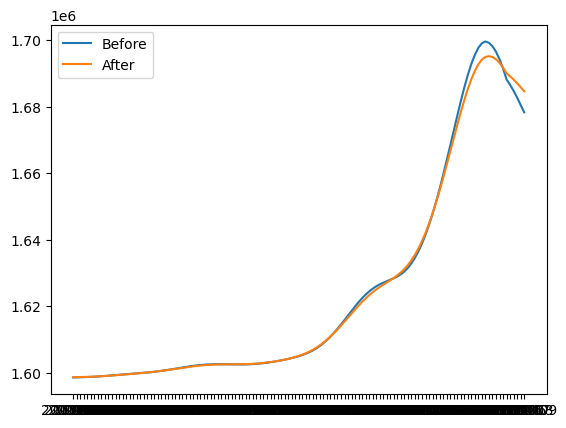

In [13]:
plt.plot(swe_pop_grouped_band.iloc[4,2:],label = "Before")
swe_pop_grouped_band.iloc[:,2:] = ma_smoothing(swe_pop_grouped_band.iloc[:,2:],window_size = 12)
plt.plot(swe_pop_grouped_band.iloc[4,2:],label = "After")
plt.legend()


In [10]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

print("Run Complete: "+ dt_string)

Run Complete: 14/07/2024 11:53:43
